In [1]:
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from __future__ import division
import networkx as nx
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import json

from louvain import detect_communities, modularity

In [3]:
##### Parameters
deg_def = [50]
flag_fn = 1 # 1 for g(v) = d(v) > 25, 4 for avg clustering coeff


max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average
MH_do = 1 # Flag for doing MH simulation
RDS_do = 1 # Flag for doing RDS simulation
RDSRR_do = 1
MHRR_do = 1

SHOW_VAR_CONVG = 0
ABS_ERROR = 1

In [4]:
def node_fn(node):
    if flag_fn == 1:
        temp = int(G.degree(node)>deg_def[0])
    elif flag_fn == 2:
        temp = int(G.degree(node)<deg_def[1])
    elif flag_fn == 3:
        temp = G.degree(node)
    elif flag_fn == 4:
        deg = G.degree(node)
        if deg < 2:
            temp = 0
        else:
            temp = 2*nx.triangles(G,node)/(deg*(deg-1))
    else:
        print("Not a defined a function")
        sys.exit(0)
    return temp

In [5]:
G = nx.read_edgelist("friendster_community1_trimmed.edgelist",nodetype = int)

G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()

print(G_no_edges,G_no_nodes)

1246479 64600


In [6]:
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.2657120743034056


In [7]:
partition = detect_communities(G, randomized=False)
community_map = {}
node_map = {}
for community, nodes in enumerate(partition):
    for node in nodes:
        node_map[node] = community
    community_map[community] = nodes
print(len(community_map))

144


In [8]:
def MH_sampling(G,B):
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample_t = np.random.choice(neighbors)
        if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
            sample = sample_t
        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)
def RDS_sampling(G,B):
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample = random.choice(neighbors)
        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)
def RDSRR_sampling(G,B,U=None):
    M = np.power(B,2/3)
    restart_ind = np.power(np.arange(1,M),1.5)
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample = random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)
def MHRR_sampling(G,B,U=None):
    M = np.power(B,2/3)
    restart_ind = np.power(np.arange(1,M),1.5)
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample_t = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

1 Done
3 Done


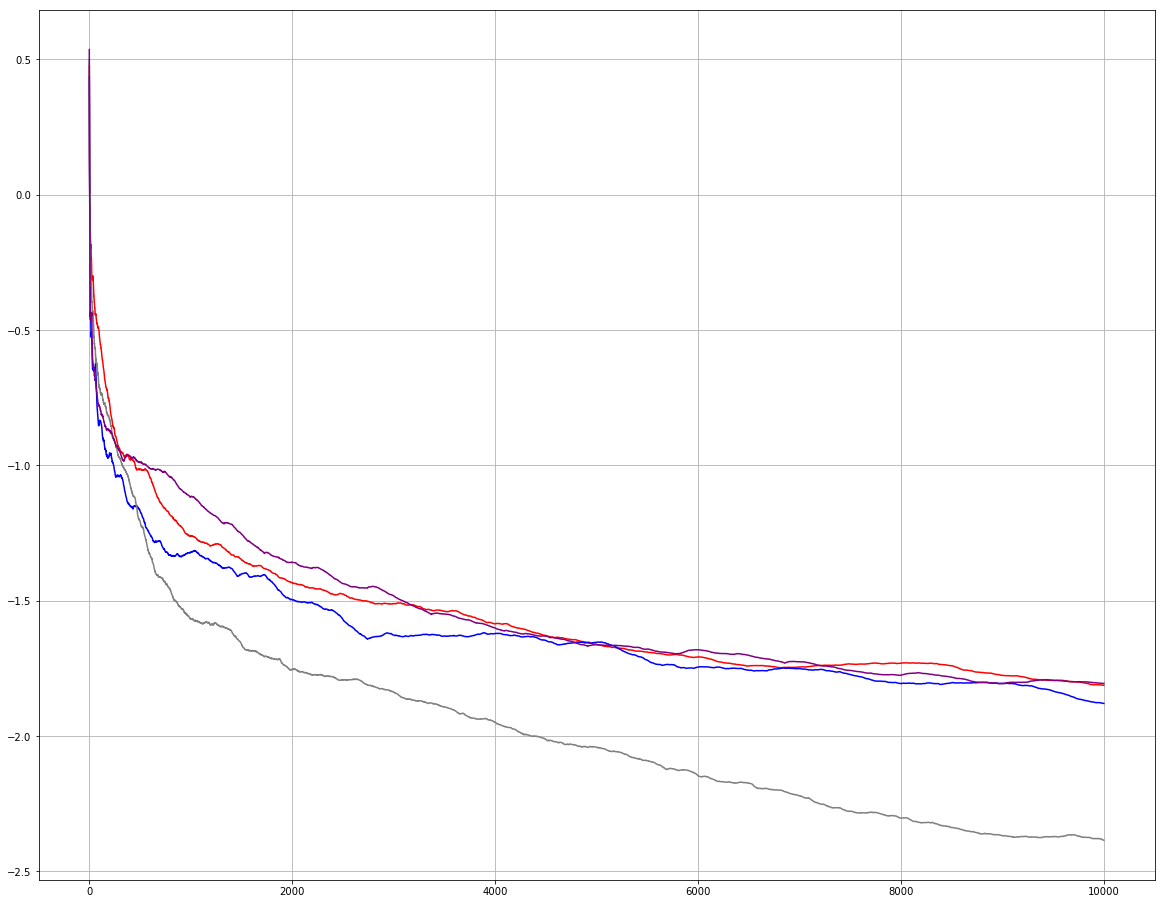

In [9]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org
print('1 Done')

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org
print('3 Done')

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

plt.figure(1,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),np.log(MSE_MH),color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),np.log(MSE_mhrr),color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),np.log(MSE_rds),color='gray',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),np.log(MSE_rdsrr),color='purple',linewidth=1.5)
plt.grid()

In [10]:
flag_fn = 3
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

38.59068111455108


1 Done
3 Done


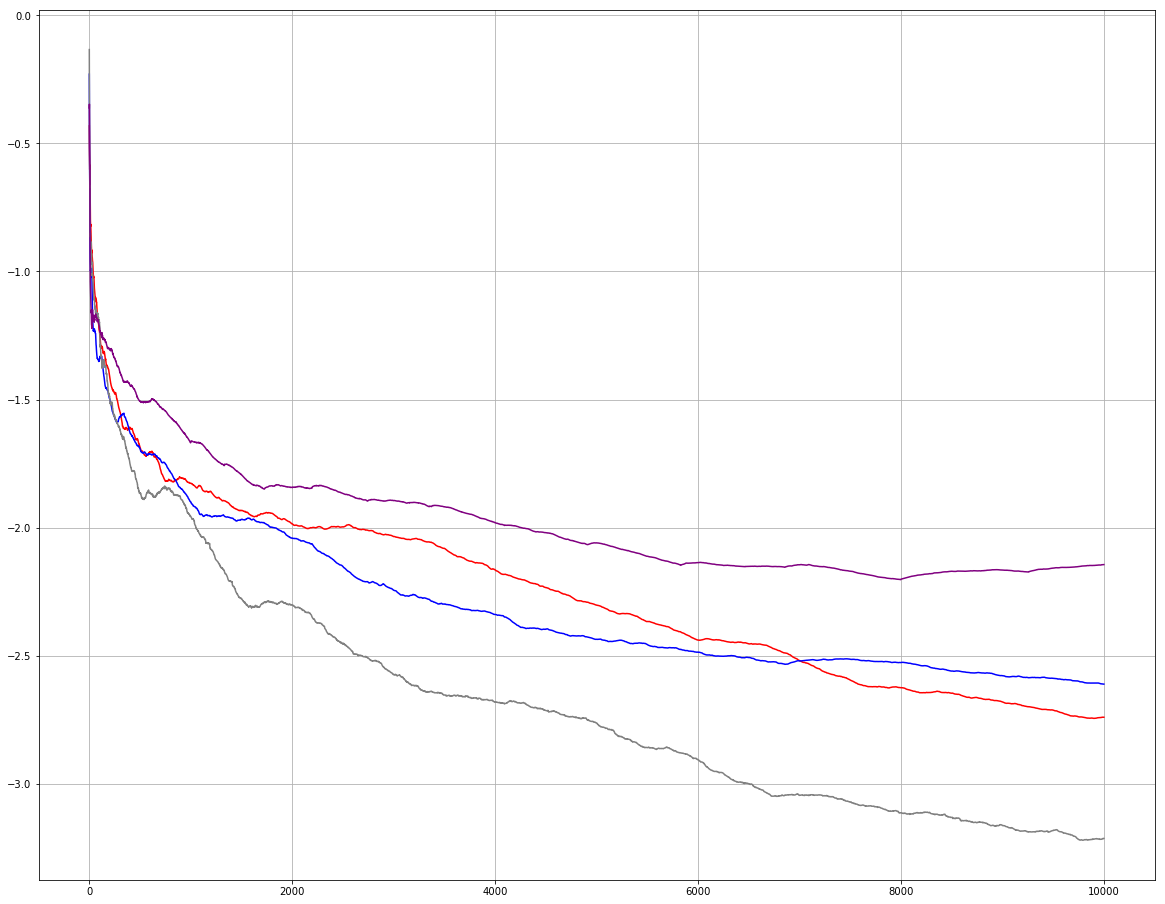

In [11]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org
print('1 Done')

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org
print('3 Done')

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

plt.figure(2,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),np.log(MSE_MH),color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),np.log(MSE_mhrr),color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),np.log(MSE_rds),color='gray',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),np.log(MSE_rdsrr),color='purple',linewidth=1.5)
plt.grid()

In [12]:
flag_fn = 4
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.4491010966748296


1 Done
3 Done


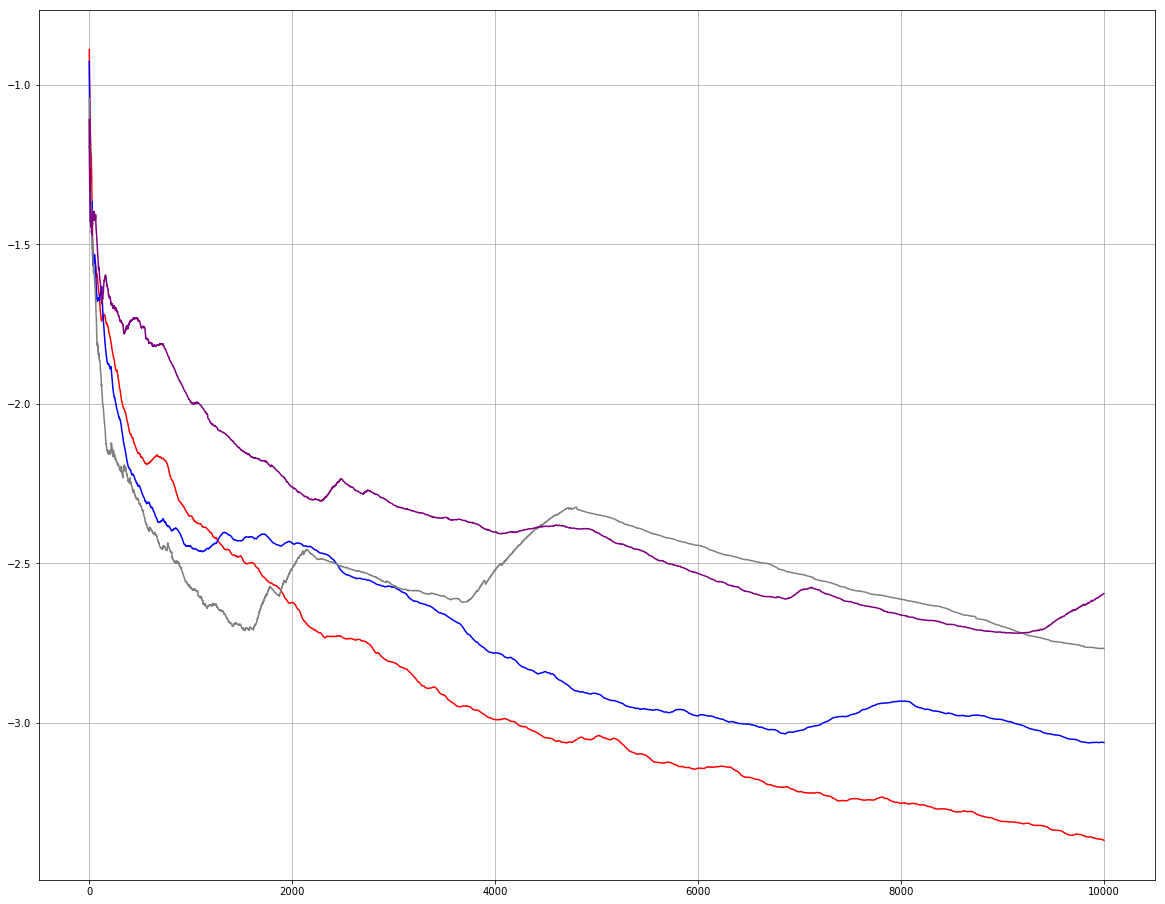

In [13]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org
print('1 Done')

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org
print('3 Done')

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

plt.figure(3,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),np.log(MSE_MH),color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),np.log(MSE_mhrr),color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),np.log(MSE_rds),color='gray',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),np.log(MSE_rdsrr),color='purple',linewidth=1.5)
plt.grid()